In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta

In [18]:
import MetaTrader5 as mt5
from account_credentials import LOGIN,PASSWORD,SERVER
from datetime import datetime


is_initialized = mt5.initialize()
print('initialize: ', is_initialized)

is_logged_in = mt5.login(LOGIN, PASSWORD, SERVER)
print('logged in: ', is_logged_in)
print('\n')
account_info = mt5.account_info()
print(datetime.now(),
    '| Login: ', account_info.login,
    '| Balance: ', account_info.balance,
    '| Equity: ' , account_info.equity)

symbol = 'XAUUSD'
number_of_date= 10000
timeframe = mt5.TIMEFRAME_H1
from_date = datetime.now()

df = pd.DataFrame(mt5.copy_rates_from(symbol,timeframe,from_date,number_of_date))
df["time"] = pd.to_datetime(df["time"], unit="s")
df = df.rename(columns={'time': 'date','tick_volume':'volume'})
df = df[['date','open','high','low','close','volume']]
df = df.set_index("date")
print(df.head()) # just to make sure that sorted from old to new

initialize:  True
logged in:  True


2023-04-20 10:12:18.120659 | Login:  114123121 | Balance:  522.59 | Equity:  523.13


                         open      high       low     close  volume
date                                                               
2021-08-10 12:00:00  1732.395  1733.745  1726.227  1727.672    6474
2021-08-10 13:00:00  1727.645  1729.903  1721.020  1721.931   10099
2021-08-10 14:00:00  1721.963  1727.258  1717.741  1726.512    9855
2021-08-10 15:00:00  1726.482  1732.713  1725.512  1731.500    5555
2021-08-10 16:00:00  1731.468  1732.430  1729.202  1729.405    3733


##### Adding Features

In [20]:
df['RSI'] = ta.rsi(df.close, length = 15)
df['EMAF'] = ta.ema(df.close, length = 20)
df['EMAM'] = ta.ema(df.close, length = 100)
df['EMAS'] = ta.ema(df.close, length = 150)
# df['Target'] = df['close'] - df.open
# df['Target'] = df['Target'].shift(-1)

# df['TargetClass'] = [1 if df.Target[i] > 0 else 0 for i in range(len(df))]
df['Target-Next-Close'] = df['close'].shift(-1)



df.dropna(inplace = True)
df.reset_index(inplace = True)
df.drop(['date','volume'], axis=1 , inplace=True)
df

,open,high,low,close,RSI,EMAF,EMAM,EMAS,Target-Next-Close
0,1788.288,1788.889,1787.130,1787.419,52.167617,1786.470292,1775.545823,1766.097253,1784.401
1,1787.417,1787.455,1784.101,1784.401,46.055288,1786.273216,1775.721173,1766.339687,1781.882
2,1784.447,1785.409,1781.516,1781.882,41.687298,1785.855005,1775.843170,1766.545546,1780.905
3,1781.871,1782.370,1780.493,1780.905,40.106605,1785.383576,1775.943404,1766.735737,1779.916
4,1780.909,1780.909,1774.199,1779.916,38.522362,1784.862855,1776.022069,1766.910310,1777.501
...,...,...,...,...,...,...,...,...,...
9845,1994.615,1995.699,1994.096,1994.506,50.424397,1992.910375,2002.323161,2003.654718,1993.653
9846,1994.480,1994.707,1993.150,1993.653,49.422603,1992.981101,2002.151475,2003.522244,1995.644
9847,1993.688,1996.682,1993.505,1995.644,51.816584,1993.234711,2002.022614,2003.417897,1995.715
9848,1995.623,1998.580,1992.198,1995.715,51.903565,1993.470929,2001.897711,2003.315872,1991.769


In [21]:
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler(feature_range=(0,1))
# data_set_scaled = sc.fit_transform(df)
# data_set_scaled

In [22]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data_set_scaled = sc.fit_transform(df)
data_set_scaled[:,8]


array([-0.38742715, -0.41610418, -0.42722664, ...,  2.01823317,
        1.97331075,  1.96966778])

In [23]:
X = []
backcandles = 30
print(data_set_scaled.shape[0])
for j in range(8): # grabe open	high	low	close	RSI	EMAF	EMAM	EMAS
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

9850


In [24]:
X=np.moveaxis(X, [0], [2])
X.shape

(9820, 30, 8)

In [25]:
X = np.array(X)
y = np.array(data_set_scaled[backcandles:,-1])
# y = np.reshape(y,(len(y),1))
print(X.shape) # 3D X has 8 colume and each colume contain xx backcandles (row, backcandle, column)
print(y.shape) # 2D contain 1 value (it's 1D array that reshape into 2D array)
print(y[0:10])

(9820, 30, 8)
(9820,)
[-0.37614532 -0.40823764 -0.41734507 -0.38163255 -0.38540075 -0.41336057
 -0.42037329 -0.40970621 -0.38139348 -0.39390481]


In [26]:
proportion = int(len(X)*0.8)
X_train, X_test = X[:proportion],X[proportion:]
y_train, y_test = y[:proportion],y[proportion:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X[1,1:10,1])

(7856, 30, 8)
(7856,)
(1964, 30, 8)
(1964,)
[-0.40046481 -0.43497509 -0.45156592 -0.46188834 -0.46216088 -0.43688287
 -0.43097785 -0.37304056 -0.35069234]


In [27]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation
from keras import optimizers
from keras.callbacks import History
import tensorflow as tf

lstm_input = Input(shape=(backcandles, 8), name = 'lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs = lstm_input, outputs = output)
adam = optimizers.Adam()
model.compile(optimizer=adam,loss='mse')
model.fit(x=X_train, y = y_train, batch_size=15, epochs=30, shuffle=True,validation_data=(X_test, y_test))

Epoch 1/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0069 - val_loss: 0.0113
Epoch 2/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 3/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 4/30
524/524 [==============================] - 5s 10ms/step - loss: 0.0036 - val_loss: 0.0054
Epoch 5/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0036 - val_loss: 0.0052
Epoch 6/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0035 - val_loss: 0.0062
Epoch 7/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 8/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 9/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 10/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0035 - val_loss: 0.004

In [28]:
y_hat = model.predict(X_test)
y_hat

62/62 [==============================] - 1s 6ms/step


array([[-0.42961577],
       [-0.4070914 ],
       [-0.38116166],
       ...,
       [ 1.9731948 ],
       [ 1.998093  ],
       [ 2.0003936 ]], dtype=float32)

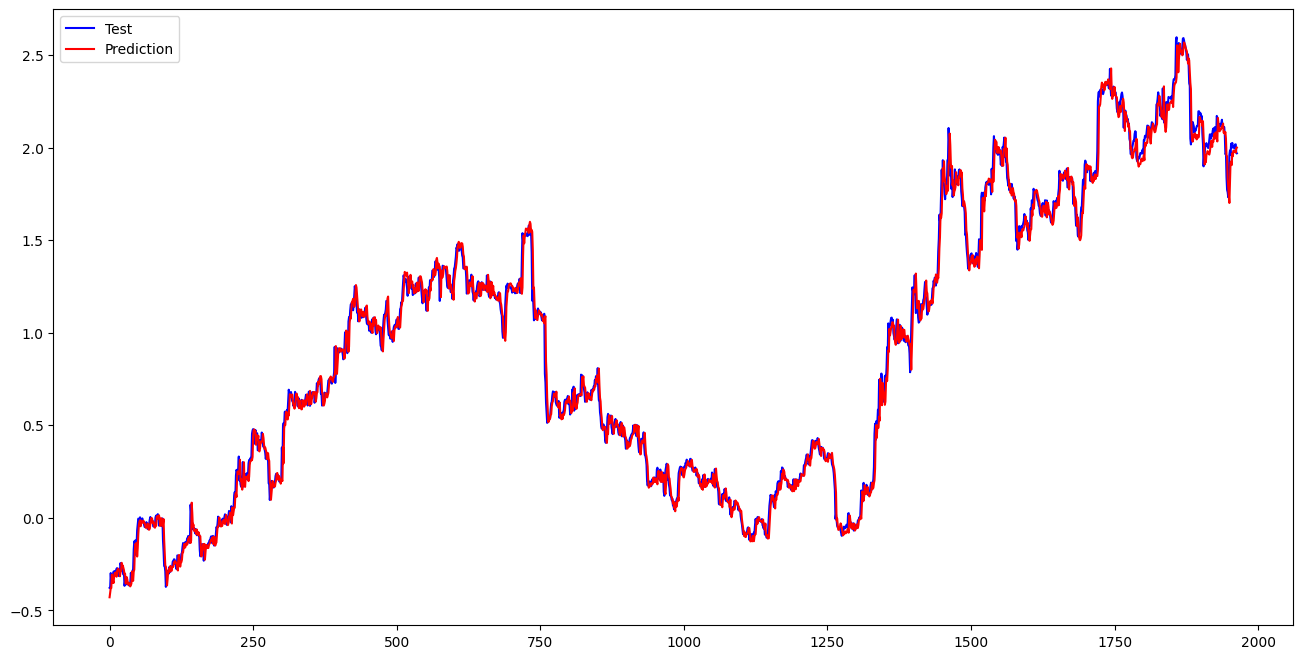

In [29]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_hat, color = 'red', label = 'Prediction')
plt.legend()
plt.show()

In [30]:
# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test)

# Print the mean squared error loss
print('Test loss:', loss)


62/62 [==============================] - 0s 5ms/step - loss: 0.0037
Test loss: 0.00374391907826066


In [31]:
# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test)

# Print the mean squared error loss
print('Test loss:', loss)

# Generate predictions on the test data
y_pred = model.predict(X_test)

# Compute the mean squared error (MSE) and root mean squared error (RMSE)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Compute the coefficient of determination (R-squared)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print("TEST SET")
print('Mean squared error (MSE):', mse)
print('Root mean squared error (RMSE):', rmse)
print('R-squared (R2):', r2)
print()

loss = model.evaluate(X_train, y_train)
print('Training loss:', loss)

y_pred = model.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_train, y_pred)
print("TRAINING SET")
print('Mean squared error (MSE):', mse)
print('Root mean squared error (RMSE):', rmse)
print('R-squared (R2):', r2)

62/62 [==============================] - 0s 5ms/step - loss: 0.0037
Test loss: 0.00374391907826066
62/62 [==============================] - 0s 4ms/step
TEST SET
Mean squared error (MSE): 0.0037439195528815162
Root mean squared error (RMSE): 0.06118757678550047
R-squared (R2): 0.9937754712420649

246/246 [==============================] - 1s 5ms/step - loss: 0.0029
Training loss: 0.0029252544045448303
246/246 [==============================] - 1s 5ms/step
TRAINING SET
Mean squared error (MSE): 0.0029252535901971815
Root mean squared error (RMSE): 0.054085613523350014
R-squared (R2): 0.9965631950471623
